In [28]:
import gym
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import collections
import seaborn as sns

# Deep Reinforcement learning

Author : Nicholas Setijabudiharsa

TSE - Econometrics and Statistics : Data science for social science

2022

### Motivation

In order to better understand the idea of reinforcement learning, lets take an example of a game of chess. Theoritically speaking, one can create an brute force algorithm that analyze all possible states of the game and takes into account all the possible states that can come after the current state, and take the action that give the most probability of winning at the end. However, this method is very inefficient. In 2021, [John Tromp](https://github.com/tromp/ChessPositionRanking) did an analysis and found that there are about $4.8 x 10^{44}$ possible combinations of legal chess positions in chess. For perspective, here is the full form of that number

$$480000000000000000000000000000000000000000000$$

So for sure, this process is very inefficient. This is where Reinforcement learning comes in handy.

In this notebook, we will first discuss the [definitions and the framework](https://www.davidsilver.uk/wp-content/uploads/2020/03/intro_RL.pdf) often used in most RL courses you see online, then, we will explore a little bit about what is a [Markov Decision Process](https://www.davidsilver.uk/wp-content/uploads/2020/03/MDP.pdf) (MDP), then, we will talk about how we can [approximate our value function](https://www.davidsilver.uk/wp-content/uploads/2020/03/FA.pdf) using Q learning and DQN, additionally, we will explore as well some methods from the [rainbow paper](https://arxiv.org/pdf/1710.02298.pdf) and [policy gradient](https://www.davidsilver.uk/wp-content/uploads/2020/03/pg.pdf)

## Definitions and  Framework of Rinforcement Learning

We firstly define :
- **State space** $S$ to be the space of all the parameters of our environment that can help us to understand our environment better
- **Action space** $A$ to be the space of all possible action we can take in a given environment. 

the classic example that we often see to better understand this notion is for example the atari game Breakout. Our agent (the paddle) will need the state space to be able to let it understand the environment best, therefore $S$ will be the tuple of all the coordinates of bricks that are still not yet hit by the ball, the coordinate of the ball, and the coordinate of the paddle. and the set $A$ is simply a set of 2 actions whether the paddle to go left or right.


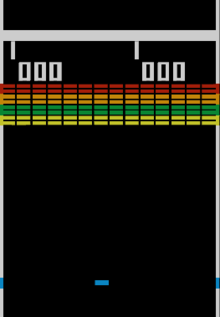
Source : [Wikipedia](https://en.wikipedia.org/wiki/Breakout_(video_game))



We can now define another common terminology which is the **policy** $\pi$ in the topic. A policy $\pi$ is a mapping from the state space to an action space that simply represents the agent to take an action $a$ from a state $s$ i.e.

$$
\begin{align*}
  \pi \colon S &\to A \\
  s &\mapsto a
\end{align*}
$$
_Remark : the policy function can be deterministic $\pi(s) = a$ or stochastic policy where $\pi(a|s) = \mathbb{P}[A=a | S=s]$_

Let us now define the notion of **value function** which is a function that represents a measure of how good of a state / action is for our agent and is represented by the expected of future rewards

$$
v_{\pi(s)} = \mathbb{E}_\pi[R_{t+1} + R_{t+2} + \dots | S_t = s]
$$

For our application, it is suffices to assume an agent is defined by their policy function $\pi$ and their value function $v$.

Reinforcement learning is the process optimizing an agent's action $a \in A$ with $A$ to be defined as the action space of our environment, and a given state $s\in S$ with $S$ to be the state space of our environment, and by optimizing it's policy $\pi(s, a)$ where $\pi(s, a) = Pr(a=a | s=s)$ the stochastic version of the policy, such that it maximizes the total rewards of the agent. In other words, reinforcement learning is a **maximization problem** where we **optimize** our agent's _policy_ to **maximize** future rewards.

Taking the chess as our example, the state space will contains all the possible legal positions of each pieces in the board. and the action space can be defined as a pair of $(p, l_target)$ where $p \in [King, Queen, Horse, etc]$ is the piece that is to be moved and $l_{target} \in \mathbb{R}^2$  is the location that the piece is being moved to.

An environment where we get an information about the reward after every action an agent take, is called **Dense** rewards, for example, minesweeper, on the other hand, environment such as playing a simple game of chess where we only receive rewards at the end of the game (whether we win or loses), is called **Sparse** rewards, naturally, the denser the rewards, the more efficient our data will be and therefore faster our learning will be.

## Markov Decision Process (MDP)

A state $S_t$ is Markov if and only if the distribution of future state can be fully observed simply by looking at the last state. In other words

$$
\mathbb{P}[S_{t+1}|S_1, \dots S_t] =\mathbb{P}[S_{t+1}| S_t]
$$

A markov process can then be defined by the tuple $(\mathcal{S}, \mathcal{P})$ where $\mathcal{S}$ is a finite set of states, and $\mathcal{P}$ to be the state transition probability matrix such that each element represents $P_{ss'} = \mathbb{P}[S_{t+1} = s' | S_t = s] $

Thus, we can now understand that an Markov Decision Process (MDP) is an extension of a markov process with 3 additional parameters:
- **$\mathcal{A}$** to be the finite set of actions
- **$\mathcal{R}$** to be the reward function defined on the action level s.t.
$$
R^a_s = \mathbb{E}[R_{t+1}|S_t=s, A_t = a]
$$
- **$\gamma$** to be the discount factor of future rewards defined on the $[0, 1] \subset \mathbb{R}$

*Remark: Another consequences of this, is that we dont take the future states with certainty but instead given a current state $s_t$, we assume that $s_{t+1}$ adopts a certain probability distribution. For example, any games that includes rolling a dice contains an element of randomness that originates from the random variable of the dice number.*

It is important now to define what is a **state-value function** and the **action-value** function. While both of them are quite similar in a sense that they are both defined on a given MDP, and both represents some sort of value, there is indeed a slight difference. 
- The **State value** function of and MDP is the expected return from state s when following policy $\pi$ at time $t$

$$
v_\pi(s) = \mathbb{E}_\pi[\overbrace{ \sum_{k=0}^\infty \gamma^k R_{t+k+1}}^\text{total future discounted rewards := $G_t$} | S_t = s]
$$


- where **Action value** function of and MDP is the expected return from state s when following policy $\pi$ **and taking action a** at time $t$.

$$
q_\pi(s, a) = \mathbb{E}_\pi[G_t| S_t = s, A_t = a]
$$

It is worth noting that the relationship between $v_\pi(s)$ and $q_\pi(s, a)$ are the following:

$$
v_\pi(s) = \sum_{a \in A} \pi(a|s) \times q_\pi(s, a)
$$



### Existence theorem

A theorem related to the MDP states that for any MDP:
- $\exists \pi^* s.t. v_{\pi^*}(s) \geq v_{\pi}(s) \forall s \in \mathcal{S}, \forall \pi $ where:
    - $v_{\pi^*}(s) = v^*(s)$
    - $q_{\pi^*}(s, a) = q^*(s, a)$

*Remark: Assuming we observe all of our environment, the $\pi^*$ can be found by a greedy algorithm that iteratively modifies $\pi_{t+1}(s) = \text{argmax}_{a\in\mathcal{A}} q_\pi(s, a)$ until there is no more improvements can be made or a stopping criterion has been attained*


### Estimation of state value function

We can estimate our state value function $v_\pi(s)$ using different methods, in particular we will discuss _Monte-Carlo_(MC) learning, and _Temporal-difference_(TD).



#### Monte-Carlo methods

Ever heard of **"learning by doing"** ? This is the simple idea behind every monte carlo method. With this method, we estimate the state value function as the average returns we get when visiting a particular state. 

In other words, it is an estimation method of our value function by updating the value function $V(s)$ with the empirical mean of the value of the states after each iteration. 

In a more concrete manner, the algorithm works by the following:

1. Initialize $\pi$, $V$, and $R$ nested array of returns history for every possible states $s$
2. Repeat:
    - Generate an episode following $\pi$
    - For every state $s$ in $S$ in the episode:
        - add returns of s in the episodes to the R(s)
        - update V(s) as the average of the R(s)

i.e. note that by law of large numbers, we have that $V(s) \rightarrow v_\pi(s)$

We can also recall that :


$$
\begin{aligned}
\mu_k &= \frac{1}{k} \sum_{j=1}^k x_j \\
&= \frac{1}{k} (x_k + \sum_{j=1}^{k-1} x_j) \\
&= \frac{1}{k} (x_k + (k-1) \mu_{k-1})\\
&= \mu_{k-1} + \frac{1}{k} (x_k - \mu_{k-1}) )\\
\end{aligned}
$$

Thus, this allow us to update the $V(s)$ incrementally by setting $V(s)$ at time t by $V(s) + \frac{1}{n_s} (G^s_t - V(s))$, normally we consider an $\alpha$ to be a learning rate and the new update formulation would be:

$$
V(s_t) = V(s_t) + \alpha (G^s_t - V(s_t))
$$

#### Example

We will look into an implementation of MC using a black jack gym environment.

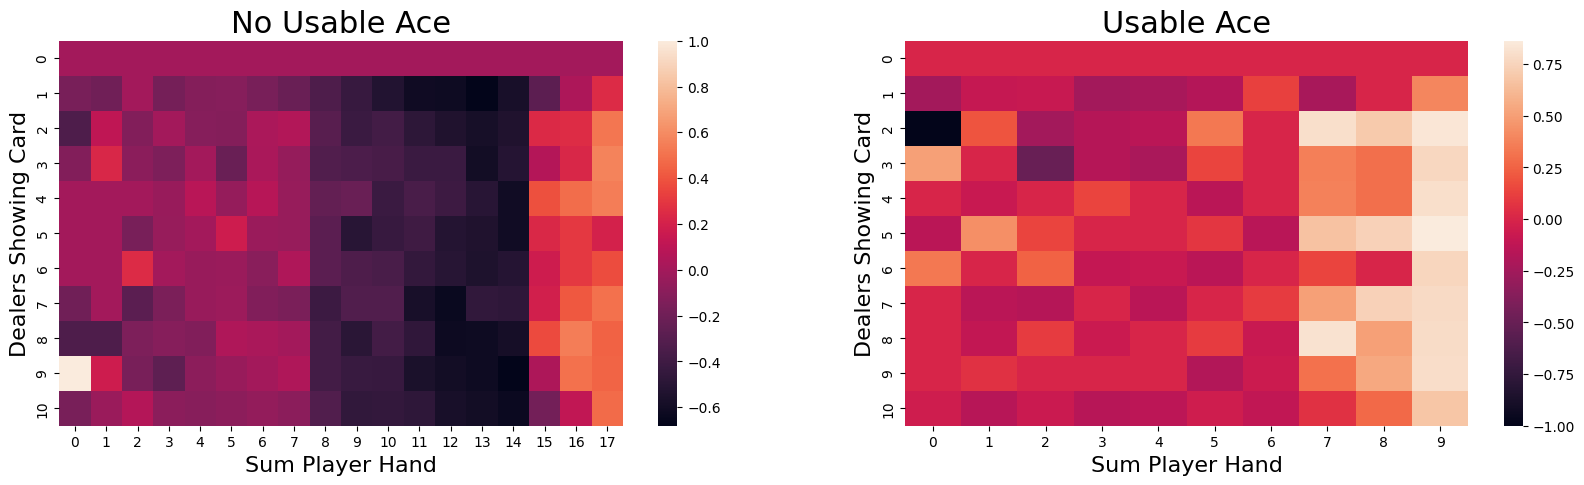

In [51]:
# source of inspiration : https://github.com/AdamOlsson/rl_blackjack/blob/master/fv_mc_prediction.py

def MC(env, discount_factor=1.0, iterations = 100):
    vfn = collections.defaultdict(float)
    states_count = collections.defaultdict(int)
    returns = collections.defaultdict(float)
    for i in range(iterations):
        episode = play_episode(env)
        G = 0
        states_in_episode = list(set([sar[0] for sar in episode]))
        for t, (state, action, reward) in enumerate(episode):
            G = G*discount_factor + reward
            if not state in states_in_episode[0:t]:
                returns[state] += G
                states_count[state] += 1
                vfn[state] = returns[state] / states_count[state]
    return vfn
            

def play_episode(env):
    episode = []
    state = env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

env = gym.make('Blackjack-v1')

vfn = MC(env, iterations=10000)

states_0 = np.zeros([32,11])
states_1 = np.zeros([32,11])

for (s0,s1,s2), v in vfn.items():
    if s2:
        states_1[s0][s1] = v
    else:
        states_0[s0][s1] = v

fig = plt.figure(figsize=(20,5))
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

Z = states_0
Z = Z[~np.all(Z == 0, axis=1)].T
ax0 = sns.heatmap(Z, ax=ax0)
Z = states_1
Z = Z[~np.all(Z == 0, axis=1)].T
ax1 = sns.heatmap(Z, ax=ax1)

ax0.set_title('No Usable Ace', fontsize=22)
ax1.set_title('Usable Ace', fontsize=22)

ax0.set_xlabel('Sum Player Hand', fontsize=16)
ax1.set_xlabel('Sum Player Hand', fontsize=16)

ax0.set_ylabel('Dealers Showing Card', fontsize=16)
ax1.set_ylabel('Dealers Showing Card', fontsize=16)


plt.show()

#### Temporal Differences

Temporal Differences uses the estimated return of the next steps in constrast with the MC methods that uses the discounted rewards of the state it self.

Tn other words at every iteration $V(S_t) = V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))$ with the following elements:
- $\gamma$ to be the discount factor of future values
- $R_{t+1}$ to be the rewards received at t+1 following the policy $\pi$
- $V(S_{t+1})$ to be the state value of being in the next state at time t+1

**Remark: $R_{t+1} + \gamma V(S_{t+1})$ is often called temporal difference target and it represents the estimated return consisting of future rewards and the value of being in the future state**

This method is the simplest form of TD usually noted as TD(0). The idea is to basically look into the immediate next step, at after being in the state S. 

To take this method further, we can look into the next n-step often also called TD($\lambda$). In other words when we consider n=1, 2, $\infty$:


$$
\begin{aligned}
n=1 & \rightarrow G_t^1 = R_{t+1} + \gamma V(S_{t+1})\\
n=2 & \rightarrow G_t^2 = R_{t+1} + \gamma R_{t+2} + \gamma^2 V(S_{t+2})\\
\vdots \\
n=\infty & \rightarrow G_t^\infty = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T-1} R_T \implies MC
\end{aligned}
$$

#### Example

In [ ]:
# source of inspiration : https://github.com/AdamOlsson/rl_blackjack/blob/master/fv_mc_prediction.py

def TD(env, discount_factor=1.0, iterations = 100):
    vfn = collections.defaultdict(float)
    states_count = collections.defaultdict(int)
    returns = collections.defaultdict(float)
    for i in range(iterations):
        episode = play_episode(env)
        G = 0
        states_in_episode = list(set([sar[0] for sar in episode]))
        for t, (state, action, reward) in enumerate(episode):
            G = G*discount_factor + reward
            if not state in states_in_episode[0:t]:
                returns[state] += G
                states_count[state] += 1
                vfn[state] = returns[state] / states_count[state]
    return vfn
            

def play_episode(env):
    episode = []
    state = env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

env = gym.make('Blackjack-v1')

vfn = first_visit_MC_prediction(env, iterations=10000)

states_0 = np.zeros([32,11])
states_1 = np.zeros([32,11])

for (s0,s1,s2), v in vfn.items():
    if s2:
        states_1[s0][s1] = v
    else:
        states_0[s0][s1] = v

fig = plt.figure(figsize=(20,5))
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

Z = states_0
Z = Z[~np.all(Z == 0, axis=1)].T
ax0 = sns.heatmap(Z, ax=ax0)
Z = states_1
Z = Z[~np.all(Z == 0, axis=1)].T
ax1 = sns.heatmap(Z, ax=ax1)

ax0.set_title('No Usable Ace', fontsize=22)
ax1.set_title('Usable Ace', fontsize=22)

ax0.set_xlabel('Sum Player Hand', fontsize=16)
ax1.set_xlabel('Sum Player Hand', fontsize=16)

ax0.set_ylabel('Dealers Showing Card', fontsize=16)
ax1.set_ylabel('Dealers Showing Card', fontsize=16)


plt.show()

### Estimation of action value function with Q-value

Given our framework of reinforcement learning defined above, we can now discuss about the framework of *Q learning*. Q learning is a reinforcement learning policy that is based on the process of assigning a certain value Q for every state and action pair and this process boils down to generate a function Q such that with the goal of estimating an **action-value function** such that:

$$
\begin{align*}
  Q \colon (S \times A) &\to \mathbb{R} \\
  (s, a) &\mapsto q.
\end{align*}
$$

Where if $s \in S$ and $a \in A$, we have $Q(s, a)$ represents the value of the action $a$ when taken at a state $s$ and the optimal $Q^*(s, a)$ is one that represents $max_\pi\mathbb{E}[\sum_{t'=t}^T\gamma^{t'-t}r_{t'} | s_t=s, a_t=a, \pi]$ with T being the final state of our environment.

The algorithm updates the Q function using the **Bellman equation** which is an iterative method that updayes a new function using the weighted average of the current value and the new information, assuming we wil always take the best action.

$$
Q^{new}(s_t, a_t) =  (1-\underbrace{\alpha}_\text{learning rate})\overbrace{Q(s_t, a_t)}^\text{Current value}  + \underbrace{\alpha}_\text{learning rate} \times ( \overbrace{r_t}^\text{current reward} + \underbrace{\gamma}_\text{discount factor} \times \overbrace{max_a Q(s_{t+1}, a)}^\text{future value while action maximized} )
$$


Thus in a nutshell, the algorithm works as the following:

```
Q function is initialized by the programmer to an arbitrary value
For every episode t:
    Initialize S
    For every step of episode:
        Choosing an A from S using policy derived from Q
        Take action A
        Observe a reward R
        Update Q based on the Bellman equation
        S = S'
    Until S is the terminal
If stopping cretiria is met (number of episodes reached t or Q function is not changed) then stop
```

note that the Q function in ourcase for a discrete state and action space, it can very be a matrix with a bijection from each row to the state space and each column to the action space.


## Deep Q Network

### $\epsilon$-greedy

We recall that a greedy policy improvement over $Q(s, a)$ is $$\pi'(s)=\text{argmax}_{a \in \mathcal{A}} Q(s, a)$$

We define a $\epsilon$-greeedy policy is the simplest idea to ensure a we keep exploring even when we are happy enough with our exploitation such that every action will be played with a non-zero probability.

## [QUESTION AT PAGE 11](https://www.davidsilver.uk/wp-content/uploads/2020/03/control.pdf)

As before, we have that $Q(s, a)$ is a mapping of a pair $s \in S$ and $a \in A$ to a certain measure of value of our agent being in the state $s$ and do an action $a$. Now then consider a situation where we are training an agent to an environment where there are 4 different states in the game and the agent can only have 2 actions. Thus, our Q function as we defined it, will have to optimize 4 x 2 different values to cover all possible state and action pair. Seems easy enough!

Now assume we want to train an agent to play the popular game of FIFA, where the input is the pixels which means the state space is represented by every possible combinations of pixels in the screen, not to mention the action space in a console is much more complex. One can clearly see how complex can calculating the Q function be.

In this case, what we need is an approximation method to find our Q, and what better tool can be used to approximate a function than a neural network. This very network used to approximate the Q value is called the **Deep Q network**.

let's define this Q-network to be $Q(s, a ; w)$ with certain $w$ to be the weights of the network.

DQN works as the folowing, 
- We first take an action $a_t$ according to $\epsilon$-greedy policy
- Then we store the transition variable ($s_t$, $a_t$, $r_{t+1}$, $s_{t+1}$) in a memory set $\mathcal{D}$

### Questions
1. What is the interpretation of a target, and then what are fixed Q-targets.
2. replay memory

In [1]:
import gym
from stable_baselines import ACER
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.evaluation import evaluate_policy

import torch
from torch.autograd import Variable
import torchvision.transforms as T


import matplotlib.pyplot as plt
import copy
import random
from PIL import Image
from IPython.display import clear_output
import math
import numpy as np

import time


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/nicholas/.local/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [2]:
env = gym.make("LunarLander-v2")
episodes = 2
for ep in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render("human")
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
    print("Episode {} Score {}".format(ep, score))
env.close()

Episode 1 Score -118.9741918245818
Episode 2 Score -488.9207736703041


In [3]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

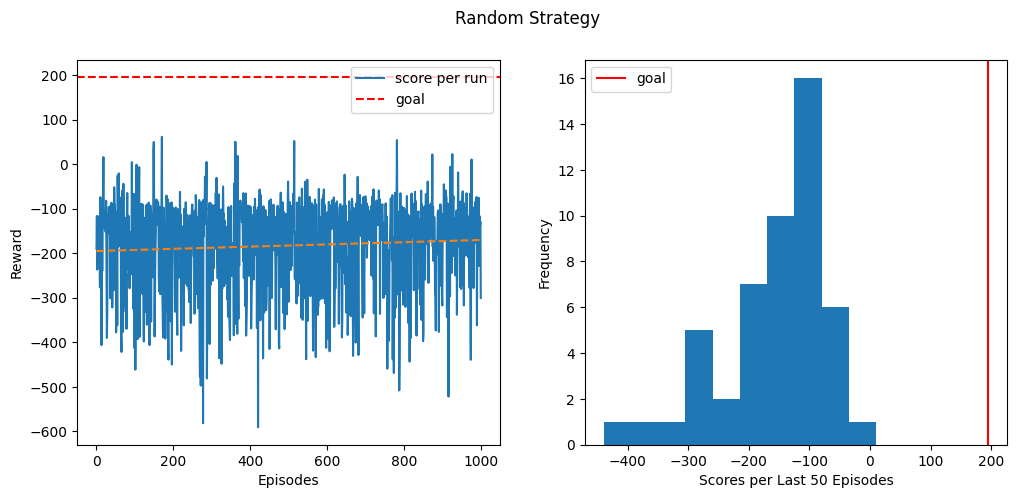

In [5]:
def random_search(env, episodes, 
                  title='Random Strategy'):
    """ Random search strategy implementation."""
    final = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total = 0
        while not done:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            total += reward
            if done:
                break
        # Add to the final reward
        final.append(total)
    plot_res(final,title)
    return final
env = gym.make("LunarLander-v2")
random_result = random_search(env, episodes=300)

In [6]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

In [7]:
def q_learning(env, model, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQL', double=False, 
               n_update=10, soft=False, verbose=True):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
        
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)
    return final



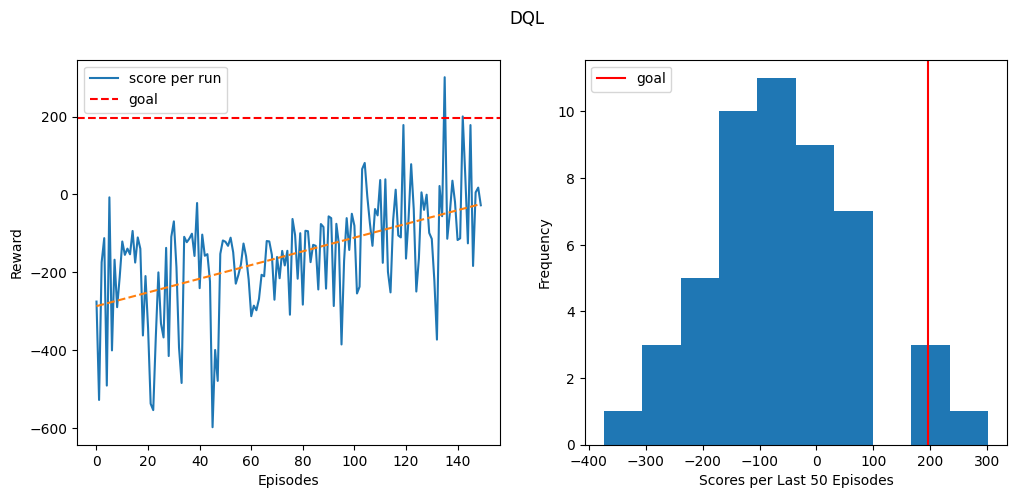

episode: 150, total reward: -28.031375278212685


In [8]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 150
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001
# Get DQN results
simple_dqn = DQN(n_state, n_action, n_hidden, lr)
simple = q_learning(env, simple_dqn, episodes, gamma=.9, epsilon=0.3)

## DQN Replay

In [9]:
# Expand DQL class with a replay function.
class DQN_replay(DQN):
    #new replay function
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())



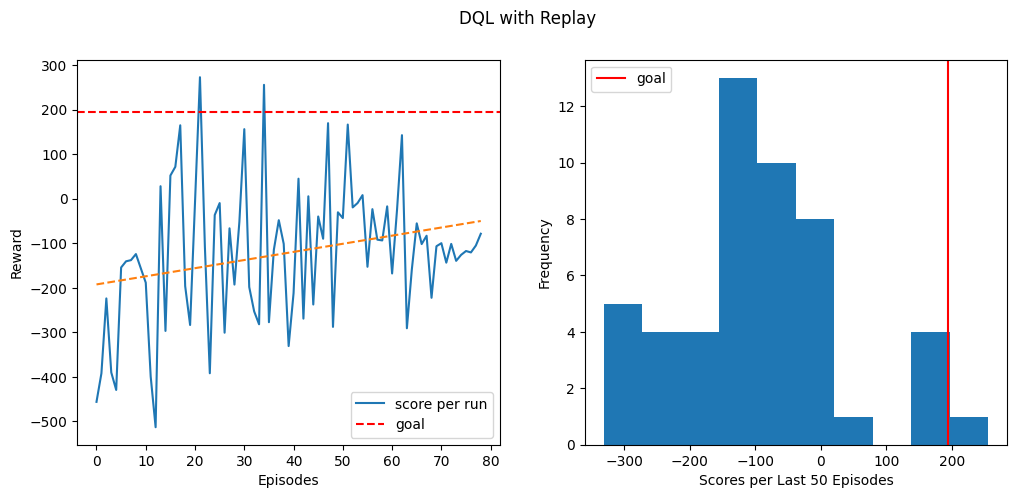

episode: 79, total reward: -78.73621734736716
Average replay time: 0.8047051822082906


KeyboardInterrupt: 

In [10]:
# Get replay results
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, 
                    episodes, gamma=.9, 
                    epsilon=0.2, replay=True, 
                    title='DQL with Replay')



### DQN Double

In [11]:
class DQN_double(DQN):
    def __init__(self, state_dim, action_dim, hidden_dim, lr):
        super().__init__(state_dim, action_dim, hidden_dim, lr)
        self.target = copy.deepcopy(self.model)
        
    def target_predict(self, s):
        ''' Use target network to make predicitons.'''
        with torch.no_grad():
            return self.target(torch.Tensor(s))
        
    def target_update(self):
        ''' Update target network with the model weights.'''
        self.target.load_state_dict(self.model.state_dict())
        
    def replay(self, memory, size, gamma=1.0):
        ''' Add experience replay to the DQL network class.'''
        if len(memory) >= size:
            # Sample experiences from the agent's memory
            data = random.sample(memory, size)
            states = []
            targets = []
            # Extract datapoints from the data
            for state, action, next_state, reward, done in data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    # The only difference between the simple replay is in this line
                    # It ensures that next q values are predicted with the target network.
                    q_v
                    alues_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            self.update(states, targets)

In [ ]:
# Get replay results
dqn_double = DQN_double(n_state, n_action, n_hidden, lr)
double =  q_learning(env, dqn_double, episodes, gamma=.9, 
                    epsilon=0.2, replay=True, double=True,
                    title='Double DQL with Replay', n_update=10)